### Notebook Description

This notebook walks through the approach for implementing a method for generating parameter samples leveraging the properties of the nullspace matrix. The goal of this implementation is to establish a preliminary baseline method for initial deployment and subsequent improvement.

The approach demonstrated here follows a one-at-a-time process, where single parameter samples are chosen from the sample space and collected into a full set to be output from the function. In later versions, this process will be replaced with a Latin-Hypercube styled approach to achieve more robust representation of the parameter space.

### Import SBML Model

Before we begin the implementation, we must use previously discussed methods to create a SciPyModel of the proper form.

In [1]:
import os, sys
NotebookDirectory = os.path.split(os.getcwd())[0]
if NotebookDirectory not in sys.path:
    sys.path.append(NotebookDirectory)
import toolbox

SciPyModel = toolbox.sbml.importSBMLFile(toolbox.createSciPyModel())
SciPyModel = toolbox.simulation.writeODEFunction( SciPyModel )
SciPyModel = toolbox.sampling.createNullSpaceFunction(SciPyModel)

### Specify Required Data

First the user must specify data on the sample space in the `SciPyModel` structure.

In [2]:
import numpy

# Specify the number of parameter sets to draw from the sample space
SciPyModel.SimulationData.Sensitivity.Global.NumSamples = 100

# Specify the minimum bounds for each parameter
SciPyModel.Parameters.MinimumValue = numpy.zeros(SciPyModel.Parameters.Quantity)

# Specify the maximum bounds for each parameter
SciPyModel.Parameters.MaximumValue = numpy.ones(SciPyModel.Parameters.Quantity)*2.

### Initialize Parameter Array

An empty numpy array is required to capture the parameter sets as they are generated one-at-a-time.

In [3]:
SciPyModel.SimulationData.Sensitivity.Global.ParameterSets = numpy.zeros([
    SciPyModel.SimulationData.Sensitivity.Global.NumSamples,
    SciPyModel.Parameters.Quantity
])

### Latin-Hypercube Sampling of Nullspace

The direct Latin-hypercube sampling approach is used to generate samples of the nullspace that are a good representation of the related system. The bounds for the nullspace parameters are given by solving the nullspace equation $K = N\cdot G$ for the steady-state nullspace given the lower and upper bounds of the parameters.

In [4]:
# Get minimum bound of Michaelis constants
MinimumEBound = SciPyModel.Parameters.MinimumValue[[
    not KineticFlag for KineticFlag in SciPyModel.Parameters.KineticFlag
]]
# Check if any bounds are zero. If so, make them a small number instead.
MinimumEBound[(MinimumEBound == 0.)] = numpy.ones(sum(
    (MinimumEBound == 0.))) * 1e-6

# Create the nullspace matrix at the minimum bound.
MinimumNullSpace = SciPyModel.ToolboxFunctions.NullSpaceFunction(
    MinimumEBound, SciPyModel.Species.Value)

# Using minimum bound of kinetic rate constants solve Ng=k
MinimumGBound = numpy.linalg.lstsq(
    MinimumNullSpace,
    SciPyModel.Parameters.MinimumValue[SciPyModel.Parameters.KineticFlag])[0]

Repeat process for maximum bound.

In [5]:
# Get maximum bound of Michaelis constants
MaximumEBound = SciPyModel.Parameters.MaximumValue[[
    not KineticFlag for KineticFlag in SciPyModel.Parameters.KineticFlag
]]
# Check if any bounds are zero. If so, make them a small number instead.
MaximumEBound[(MaximumEBound == 0.)] = numpy.ones(sum(
    (MaximumEBound == 0.))) * 1e-6

# Create the nullspace matrix at the maximum bound.
MaximumNullSpace = SciPyModel.ToolboxFunctions.NullSpaceFunction(
    MaximumEBound, SciPyModel.Species.Value)

# Using maximum bound of kinetic rate constants solve Ng=k
MaximumGBound = numpy.linalg.lstsq(
    MaximumNullSpace,
    SciPyModel.Parameters.MaximumValue[SciPyModel.Parameters.KineticFlag])[0]

Apply Latin-Hypercube sampling method to the sample space given by the min/max bounds of the Michaelis constants and nullspace parameters.

In [6]:
# Initialize sample space boundary
MinimumBound = numpy.concatenate([MinimumGBound, MinimumEBound])
MaximumBound = numpy.concatenate([MaximumGBound, MaximumEBound])

# Uniform random sample array
RanSet = numpy.random.uniform(0, 1, [
    SciPyModel.SimulationData.Sensitivity.Global.NumSamples,
    SciPyModel.Parameters.Quantity - sum(SciPyModel.Parameters.KineticFlag) +
    SciPyModel.Parameters.NullSpaceDimension
])

# Initialization of sample array
PreParameterSets = numpy.zeros([
    SciPyModel.SimulationData.Sensitivity.Global.NumSamples,
    SciPyModel.Parameters.Quantity - sum(SciPyModel.Parameters.KineticFlag) +
    SciPyModel.Parameters.NullSpaceDimension
])

# For loop to divide sample space and ensure conditions are met
for x_idx in range(
        SciPyModel.Parameters.Quantity - sum(SciPyModel.Parameters.KineticFlag)
        + SciPyModel.Parameters.NullSpaceDimension):
    idx = numpy.random.permutation(
        SciPyModel.SimulationData.Sensitivity.Global.NumSamples) + 1
    P = (numpy.transpose(idx) - RanSet[:, x_idx]
         ) / SciPyModel.SimulationData.Sensitivity.Global.NumSamples
    PreParameterSets[:, x_idx] = (MinimumBound[x_idx] + P *
                                  (MaximumBound[x_idx] - MinimumBound[x_idx]))

### Generate Parameter Sets

Finally we loop over each sample, apply the sample to the nullspace and recollect the result.

In [7]:
# Initialize colelction array
SciPyModel.SimulationData.Sensitivity.Global.ParameterSets = (numpy.empty([
    SciPyModel.SimulationData.Sensitivity.Global.NumSamples,
    SciPyModel.Parameters.Quantity
]))

# Loop over each sample
for i in range(SciPyModel.SimulationData.Sensitivity.Global.NumSamples):

    # Calculate kinetic rate constants based on current sample
    KSample = SciPyModel.ToolboxFunctions.NullSpaceFunction(
        list(PreParameterSets[i, SciPyModel.Parameters.NullSpaceDimension:]),
        list(SciPyModel.Species.Value)).dot(
            list(PreParameterSets[i, :
                                  SciPyModel.Parameters.NullSpaceDimension]))

    # Check if kinetic rate constant
    if ((KSample <
         SciPyModel.Parameters.MinimumValue[SciPyModel.Parameters.KineticFlag]
         ).any() or
        (KSample >
         SciPyModel.Parameters.MaximumValue[SciPyModel.Parameters.KineticFlag]
         ).any()):
        pass

    SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[i, :] = (
        numpy.concatenate([
            KSample.tolist()[0], PreParameterSets[
                i, SciPyModel.Parameters.NullSpaceDimension:].tolist()
        ]))

### Validate Parameter Sets

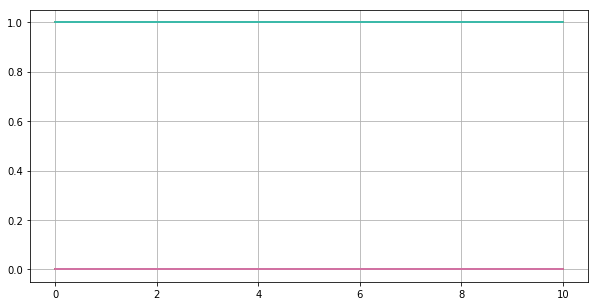

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.close()
plt.figure(figsize=(10, 5))

SciPyModel.SimulationData.TimeStart = 0
SciPyModel.SimulationData.TimeEnd = 10
SciPyModel.SimulationData.DataPoints = 100

for i in range(SciPyModel.SimulationData.Sensitivity.Global.NumSamples):

    SciPyModel.Parameters.Value = SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[
        i, :]
    SciPyModel = toolbox.simulation.integrateODEFunction(SciPyModel)
    plt.plot(SciPyModel.SimulationData.Deterministic.TimeVector,
             SciPyModel.SimulationData.Deterministic.Data)
    
plt.grid()
plt.show()

### Plot Sample Space

In [ ]:
toolbox.visuals.sampleSpace(SciPyModel)

### Notes

There should be an initialization of the sample space using the initial parameter values. Something like a square centered on the initial values and with min/max that are +/- 10% of the nominal value.